In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from torch import nn

In [2]:
# cv2.circle?
# nn.Conv2d?
# nn.MaxPool2d?
# nn.Linear?
# nn.MSELoss?

line(img, pt1, pt2, color[, thickness[, lineType[, shift]]])

circle(img, center, radius, color[, thickness[, lineType[, shift]]])

nn.Conv2d(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

nn.MaxPool2d(self, kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

nn.Linear(self, in_features, out_features, bias=True)

In [3]:
# height, width = 96, 96

In [4]:
test_df = pd.read_csv('../data/test.csv')

In [5]:
# 去除缺失项
test_df = test_df.dropna()

In [6]:
def str2array(data_str):
    data_array = np.fromstring(data_str, dtype=np.float32, sep=' ')
    return data_array

In [7]:
# y = test_df.values[:, :-1]
# y = np.array(y, dtype=np.float32)
# y = y/96.0
X = test_df.values[:, -1]
X = np.array(map(str2array, X))
X = X/255.0

In [8]:
X = X.reshape(-1, 1, 96, 96)

In [9]:
X.shape

(1783, 1, 96, 96)

In [10]:
# out_channel = y.shape[1]

In [11]:
out_channel = 30

In [12]:
class Net(nn.Module):
    def __init__(self, out_channel):
        super(Net, self).__init__()
        # (-1, 1, 96, 96)----->(-1, 16, 48, 48)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # (-1, 16, 48, 48)----->(-1, 32, 24, 24)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # (-1, 32, 24, 24)----->(-1, 64, 12, 12)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # (-1, 64, 12, 12)----->(-1, 128, 6, 6)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # (-1, 128, 6, 6)----->(-1, 128*6*6)----->(-1, 500)
        self.fc1 = nn.Linear(in_features=128*6*6, out_features=500, bias=True)
        self.fc2 = nn.Linear(in_features=500, out_features=out_channel, bias=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        x = x.view(-1, 128*6*6)
        x = self.fc1(x)
        x = self.fc2(x)
        out = x
        return out
net = Net(out_channel=out_channel)

In [13]:
net.load_state_dict(torch.load('../model/facial_keypoints_model.pt'))

In [14]:
X_tensor = torch.Tensor(torch.from_numpy(X))

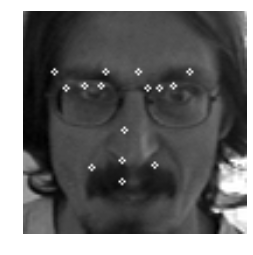

In [15]:
for i, X_samples in enumerate(X_tensor):
    data_count = i
    X_samples = X_samples.reshape(1, X_samples.shape[0], X_samples.shape[1], X_samples.shape[2])
#     print('X_samples.shape:', X_samples.shape)

    out_pred = net(X_samples)
#     print('out_pred.shape:', out_pred.shape)
#         print('out_pred:', out_pred)
    out_pred_recover = out_pred*96.0
#     print('out_pred_recover:', out_pred_recover)

    out_pred_recover_np = out_pred_recover.data.numpy()
    out_pred_recover_np = out_pred_recover_np.reshape(-1, 2)
    X_samples_np = X_samples.data.numpy()
    X_samples_np = X_samples_np * 255.0
    X_samples_np = np.array(X_samples_np, dtype=np.uint8)
    X_samples_np = X_samples_np.reshape(96, 96)
    for out_pred_recover_np_sample_x, out_pred_recover_np_sample_y in out_pred_recover_np:
        pass
#             print('out_pred_recover_np_sample_x:', out_pred_recover_np_sample_x)
#             print('out_pred_recover_np_sample_y:', out_pred_recover_np_sample_y)
        cv2.circle(X_samples_np, center=(int(out_pred_recover_np_sample_x), int(out_pred_recover_np_sample_y)), radius=1, color=255, thickness=1)
    plt.imshow(X_samples_np, cmap='gray')
    plt.axis('off')
    if i == 12:
        break

In [16]:
out_pred = net(X_tensor)
#     print('out_pred.shape:', out_pred.shape)
#         print('out_pred:', out_pred)
out_pred_recover = out_pred*96.0
#     print('out_pred_recover:', out_pred_recover)

out_pred_recover_np = out_pred_recover.data.numpy()
out_pred_recover_np = np.clip(out_pred_recover_np, 0, 96)
out_pred_recover_np = out_pred_recover_np.reshape(-1)
print('out_pred_recover_np.shape:', out_pred_recover_np.shape)

('out_pred_recover_np.shape:', (53490,))


In [17]:
# out_file = open('/tmp/tmp.txt', 'wb')
# for out_pred_recover_np_val in out_pred_recover_np:
#     print(out_pred_recover_np_val)
# #     out_file.writelines(out_pred_recover_np)
# out_file.close()